## An Attempt to read images ([resource](https://rasterio.readthedocs.io/en/stable/quickstart.html))


This resource might come in handy for binary segmentation cases - [blog](https://lpsmlgeo.github.io/2019-09-22-binary_mask/)

In [46]:
#Imports

import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch

In [2]:
# Loading TIF image

raster_path = "test1.tif"
with rasterio.open(raster_path, "r") as src:
    raster_img = src.read()
    raster_meta = src.meta

image dimensions
4243
3240
what are these bounds?
BoundingBox(left=102.0913606981666, bottom=30.803728866538314, right=104.61282644993022, top=32.72914697535617)
Reading each band
(3240, 4243)
why is it rotated? - It is not always rotated!!!! OG Data from box is rotated!


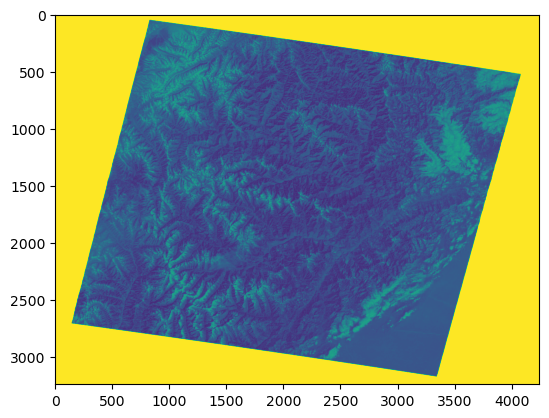

In [81]:
#Importing an image
dataset = rasterio.open('test1shp/n31_e103_multiband.tif')

#image dimensions"
print('image dimensions')
print(dataset.width)
print(dataset.height)

print('what are these bounds?')
print(dataset.bounds)

print('Reading each band')
band_id = 1
band1_values = dataset.read(band_id)
band1_array = np.array(band1_values)

print(band1_array.shape)
print('why is it rotated? - It is not always rotated!!!! OG Data from box is rotated!')
plt.imshow(band1_array)

In [14]:
bounds = dataset.bounds
print(bounds)
print(bounds[0])

BoundingBox(left=102.99958333333333, bottom=30.999583333333334, right=104.00041666666667, top=32.000416666666666)
102.99958333333333


In [15]:
print(type(bounds))

<class 'rasterio.coords.BoundingBox'>


In [16]:
#transforming back to normal coordinate system

from rasterio.transform import Affine

# Reading Labels

In [17]:
import geopandas as gpd

In [82]:
shapefile = gpd.read_file("testSHP/testSHP.shp")
print(shapefile)

   Id                                           geometry
0   0  POLYGON ((103.44181 31.32152, 103.59589 31.601...


In [83]:
print(len(shapefile))
i = 0
print(shapefile.geometry[i].exterior.coords)


1


In [84]:
i = 0

polygon_list_latlong = [(x, y) for x, y,_ in shapefile.geometry[i].exterior.coords]

print(polygon_list_latlong)
#polygon_list = [(x, y) for x, y in shapefile.geometry[1].exterior.coords]

ValueError: not enough values to unpack (expected 3, got 2)

# Attempt at making a mapped segmented

In [85]:
# Defining a mapping function:

def mapGeoToPixel(raster_image,coords):
    '''
    The input is the raster image & coordinates are in latitude and longitute. 
    '''
    bounds = dataset.bounds
    x_min = bounds[0]
    x_max = bounds[2]
    y_min = bounds[1]
    y_max = bounds[3]
    
    new_coords = []
    
    #Converting coords (origially in lat-long space to x-y space in picture)
    
    for coord in coords:
        #print(coord)
        x_coord = int((coord[0]-x_min)*(raster_image.width)/(x_max - x_min))
        y_coord = int((coord[1]-y_min)*(raster_image.height)/(y_max - y_min))   
        new_coords.append((x_coord,y_coord))
    
    return new_coords
    

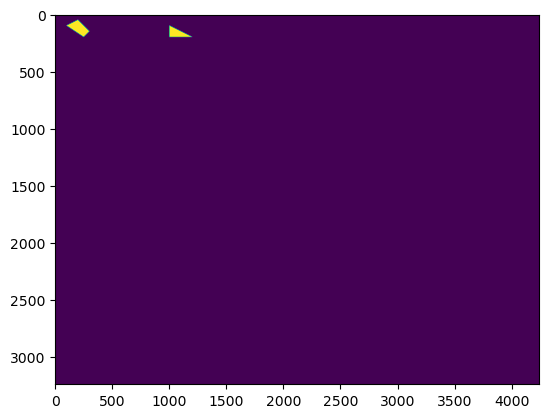

In [86]:
#Example code on how to create binary mask for segmentation

import numpy as np
from PIL import Image, ImageDraw

# Define the dimensions of the segmentation map
width = dataset.width
height = dataset.height

# Create an empty binary segmentation map
seg_map = np.zeros((height, width), dtype=np.uint8)

# Define the coordinates of the polygon vertices
polygon_coords = [(100, 100), (200, 50), (300, 150), (250, 200)]
coords2 = [(1000,100),(1000,200),(1200,200)]

# Create an Image object to draw on
seg_map_image = Image.fromarray(seg_map)
draw = ImageDraw.Draw(seg_map_image)

# Draw the polygon on the segmentation map
draw.polygon(polygon_coords, fill=1)
draw.polygon(coords2,fill=1)

# Convert the Image object back to a NumPy array
seg_map = np.array(seg_map_image)

# Print the segmentation map
plt.imshow(seg_map)

In [87]:
#Example code on how to create binary mask for segmentation

# Define the dimensions of the segmentation map
width = dataset.width
height = dataset.height

# Create an empty binary segmentation map
seg_map = np.zeros((height, width), dtype=np.uint8)

# Create an Image object to draw on
seg_map_image = Image.fromarray(seg_map)
draw = ImageDraw.Draw(seg_map_image)

# Define the coordinates of the polygon vertices
for i in range(len(shapefile.geometry)):
    #polygon_list_latlong = [(x, y) for x, y,_ in shapefile.geometry[i].exterior.coords]
    polygon_list_latlong = [(x, y) for x, y in shapefile.geometry[i].exterior.coords]
    #print(i)
    polygon_list = mapGeoToPixel(dataset,polygon_list_latlong)


    # Draw the polygon on the segmentation map
    draw.polygon(polygon_list, fill=1)
    

#All changes are done to 'draw' and so, to 'seg_map_image'

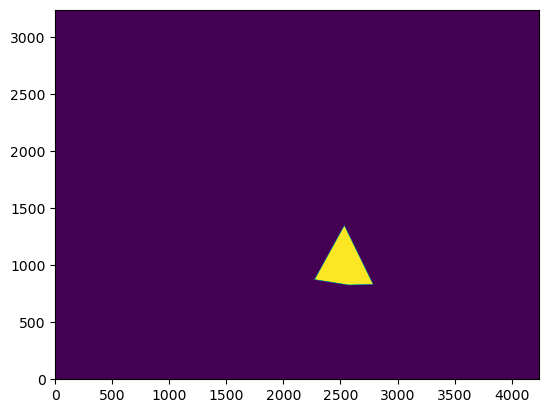

In [95]:
# Convert the Image object back to a NumPy array
seg_map = np.array(seg_map_image)

# Print the segmentation map
plt.imshow(seg_map,origin='lower')

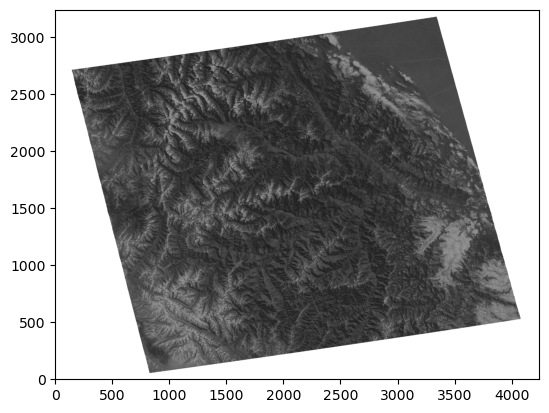

In [96]:
#Converting the segmented_map to a tensor

seg_map_tensor = torch.from_numpy(seg_map)

#Converting the original image to a tensor

band_id = 1
band1_values = dataset.read(band_id)

plt.imshow(band1_values,origin='lower',cmap='gray')

band_values_tensor = torch.from_numpy(band1_values)

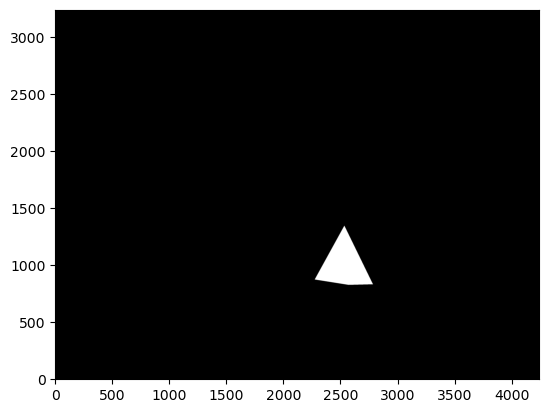

In [97]:
#Segmentation Mask

# color schemes - https://stackoverflow.com/questions/57111875/python-cmap-argument-in-matplotlib-imshow-generates-different-binary-images
# gray: 0-black 1-white
# to draw a point on co-ordinate (200,300)
#plt.plot(200, 350, marker='v', color="red")
plt.imshow(seg_map_tensor,origin='lower',cmap='gray')
#plt.show()

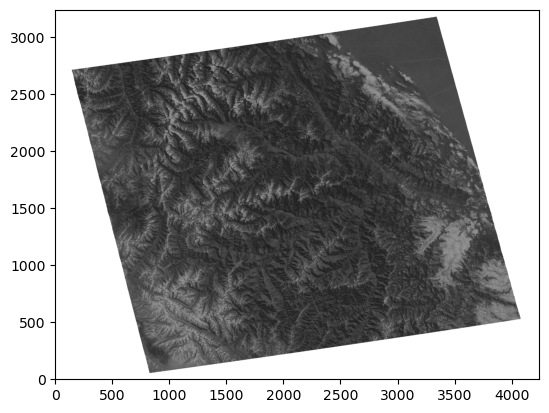

In [91]:
#Image
plt.imshow(band_values_tensor,origin='lower',cmap='gray')
#test_coordinate = [[103.25,31.25]]
#test_list = mapGeoToPixel(dataset,test_coordinate)
#print(test_list[0])
#plt.plot(test_list[0][0], test_list[0][1], marker='v', color="red")
plt.show()